**Make a square lattice and generate a set of random numbers at each lattice points and then perform metropolis algorithm and check the probabilities**

In [31]:
#load the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import time as t
from tqdm import tqdm

In [32]:
def grid_maker(nrows,ncols):
  '''
  This function generates a random classical grid of any size

  Parameters:

  - nrows: (integer) Specify the number of rows
  - ncols: (integer) Specify the number of columns

  Returns:

  The function returns your desired random grid of any size.

  '''
  if not isinstance(nrows, int) or nrows <= 0:
    raise ValueError("nrows must be a positive integer")
  if not isinstance(ncols, int) or ncols <= 0:
    raise ValueError("nrows must be a positive integer")

  grid_points = np.zeros((nrows,ncols))

  for i in range(nrows):
    for j in range(ncols):
      grid_points[i,j] = rn.choice([-1,1])

  return grid_points

# Introducing Periodic Boundary Conditions

In this boundary condition, the ends of the lattices are joined or wrapped together in order to make the lattice complete and not open ended.

In [33]:
def compute_energy(grid, mag = 'f'):
    """
    This function calculates the energy of a 2D square lattice with classical spins
    (Implements periodic boundary conditions).

    Parameters:
    - grid: input a 2D grid
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)
    Returns:
    - Energy of the lattice
    """
    energy = 0
    nrows, ncols = grid.shape

    if mag == 'f':

        for k in range(nrows):
            for l in range(ncols):
                for dk, dl in [[0, -1], [0, 1], [-1, 0], [1, 0]]:
                    ni, nj = (k + dk) % nrows, (l + dl) % ncols #implementation of periodic boundary conditions
                    energy += -grid[k, l] * grid[ni, nj]

    elif mag == 'af':

        for k in range(nrows):
            for l in range(ncols):
                for dk, dl in [[0, -1], [0, 1], [-1, 0], [1, 0]]:
                    ni, nj = (k + dk) % nrows, (l + dl) % ncols #implementation of periodic boundary conditions
                    energy += grid[k, l] * grid[ni, nj]

    return energy / 2

In [34]:
def ising_model_PBC(nsamples, temperature, grid_points, mag = 'f'):
    """
    This function runs the Ising model simulation using Metropolis-Hastings.
    (Implements periodic boundary conditions)

    Parameters:
    - nsamples: Number of samples to be taken.
    - temperature: Temperature at which the system is simulated.
    - grid_points: Takes a grid of any size.
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)
    Returns:
    - saved_energies: List of sampled energies by burning the first 20% of the sampled energies.
    - grid_points: The final grid after simulation.
    """
    if temperature <= 0:
        raise ValueError("Temperature must be positive.")

    saved_energies = []

    nrows = grid_points.shape[0]
    ncols = grid_points.shape[1]

    for n in range(nsamples):
        i, j = np.random.randint(0, nrows), np.random.randint(0, ncols)
        temp_grid = np.copy(grid_points)
        temp_grid[i, j] = -temp_grid[i, j]

        energy = compute_energy(grid_points, mag)
        temp_energy = compute_energy(temp_grid, mag)
        energy_diff = temp_energy - energy

        p_acceptance = np.exp(-energy_diff / temperature) if temperature > 0 else 0

        if energy_diff < 0 or np.random.rand() < p_acceptance:
            grid_points[i, j] = -grid_points[i, j]
            saved_energies.append(temp_energy)
        else:
            saved_energies.append(energy)

    return saved_energies[int(nsamples/5):], grid_points


 ## Calculating the specific heat capacity at the constant volume

 The specific heat of a lattice can be obtained as follows: $C_V = \frac{\langle E^2 \rangle - \langle E \rangle^2}{k_B T^2}$. In this case, we will assume $K_B$ to be 1.

In [35]:
def specific_heat_PBC(grid, temp_range, nsamples=10000, mag = 'f'):
    """
    Computes specific heat over a range of temperatures.
    (Implements Periodic Boundary Conditions)

    Parameters:
    - grid: Initial 2D Ising spin configuration.
    - temp_range: List of temperatures.
    - nsamples: Number of Monte Carlo samples per temperature.
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)
    Returns:
    - Cv: List of specific heat values.
    - updated_Cv: Filtered Cv list without NaN values.
    """
    energy_collections = []

    print("******************************************************")
    print("Collecting energies. Kindly wait.")
    print("****************************************************** \n")

    for t in tqdm(temp_range, desc='collecting energies', unit='iterations'):
        energy, _ = ising_model_PBC(nsamples, temperature=t, grid_points=grid, mag=mag)
        energy_collections.append(energy)

    print("******************************************************")
    print("Energy collection completed! Calculating Cv now.")
    print("****************************************************** \n")

    Cv = []
    for t, energies in zip(temp_range, energy_collections):
        var_energy = np.var(energies)
        Cv.append(var_energy / (t**2))

    print("******************************************************")
    print("Cv has been calculated. Refining it to remove NaN values now.")
    print("****************************************************** \n")

    updated_Cv = [c for c in Cv if not np.isnan(c)]

    print("******************************************************")
    print("Your results are ready!")
    print("****************************************************** \n")

    return Cv, updated_Cv

# Calculating the Mean energy v/s Temperature for the square lattice

The mean energy of a system in thermal equilibrium is given by:


$\langle E \rangle = \frac{\sum_i E_i e^{-E_i / k_B T}}{Z}$


where the partition function is

$Z = \sum_i e^{-E_i / k_B T}$


In [36]:
def mean_energy_PBC(grid, temp_range, nsamples=10000, mag = 'f'):
    '''
    This function calculates and gives a list of mean energy for a lattice across a given temperature range
    (Implements periodic boundary conditions)

    Parameters taken:

    - grid: Takes a 2D grid of any size.
    - temp_range: Takes a list of temperatures for which mean energy is to be calculated.
    - nsamples: How many times would you like to sample the configuration at a given temperature
                (default is 10000).
    - mag: 'f' or 'af' to select between ferromagnetic calculation or anti-ferromagnetic calculations respectively
           (By default it is set in ferromagnetic('f') state)
    Returns:

    - mean_energies: A list of calculated mean energy.
    '''
    energy_collections = []
    nrows, ncols = grid.shape
    grid = grid
    print("******************************************************")
    print("Collecting energies. Kindly wait.")
    print("****************************************************** \n")

    for t in tqdm(temp_range, desc='collecting energies', unit='temperature'):
        energy, grid = ising_model_PBC(nsamples, temperature=t, grid_points=grid, mag=mag)
        energy_collections.append(energy)

    mean_energies = []

    print("******************************************************")
    print("Energy collection completed! Calculating mean energy now.")
    print("****************************************************** \n")

    for i in tqdm(energy_collections, desc='calculating mean energy', unit='energy sample'):
        mean_energies.append(np.mean(i))

    print("******************************************************")
    print("Your results are ready!")
    print("****************************************************** \n")

    return mean_energies


# Finding Magnetization for a square lattice

Magnetization of a lattice is just the sum of all the spin orientation at each of the lattice points.

$\langle M \rangle = \frac{\sum_i M_i e^{-E_i / k_B T}}{Z}$


In [37]:
def magnetize_PBC(grid, temp_range, nsweep=10000, mag='f'):
    '''
    This function calculates and gives a list of magnetization for a square lattice across a given temperature range.
    (Implements periodic boundary condition)

    Parameters:
    - grid: Takes a 2D grid of any size.
    - temp_range: List of temperatures for which magnetic susceptibility is to be calculated.
    - nsweep: Number of samples per temperature (default is 10000).
    - mag: 'f' or 'af' for ferromagnetic or anti-ferromagnetic calculations, respectively (default: 'f').

    Returns:
    - magnetization: A list of magnetization values across all temperatures.
    '''
    magnetization_values = []
    nrows, ncols = grid.shape
    N = nrows * ncols

    for T in tqdm(temp_range, desc="Processing temperatures", unit="temperature"):
        magnetizations = [] 

        for _ in range(nsweep):
            _, grid = ising_model_PBC(nsamples=1, temperature=T, grid_points=grid, mag=mag)
            magnetizations.append(abs(np.sum(grid)) / N) 
            
        magnetization_values.append(np.mean(magnetizations))

    return magnetization_values

# Finding Magnetic Susceptibility

Magnetic susceptibility is obtained as the variance of the magnetization of the lattice at each of the temperature, divided by the corresponding temperature. This is why we need to call the ising model function carefully. We will be calling the ising model function multiple times with nsamples 1 such that we will get an ensemble of lattices for a particular temperature from which variance of magnetization can be obtained at a particular temperature.

$\chi = \frac{\langle M^2 \rangle - \langle M \rangle^2}{k_B T}$

In [38]:
def mag_susceptibility_PBC(grid, temp_range, nsweep=10000, mag='f'):
    '''
    This function calculates the magnetic susceptibility for a lattice across a given temperature range.
    (Implements Periodic Boundary Conditions)
    Parameters:
    - grid: Takes a 2D grid of any size.
    - temp_range: A list of temperatures at which susceptibility is calculated.
    - nsweep: How many times would you like to sample the configuration at a given temperature
                (default is 10000).
    Returns:
    - A list of calculated magnetic susceptibilities.
    '''

    susceptibility_values = []

    print("******************************************************")
    print("Collecting magnetization data. Kindly wait.")
    print("****************************************************** \n")

    for T in tqdm(temp_range, desc="Processing temperatures", unit="temperature"):
        magnetizations = []

        for i in range(nsweep):
            energy, grid = ising_model_PBC(nsamples=1, temperature=T, grid_points=grid, mag=mag)
            magnetization = np.sum(grid)
            magnetizations.append(magnetization)

        mean_M = np.mean(magnetizations)
        mean_M2 = np.mean(np.square(magnetizations))
        chi = (mean_M2 - mean_M**2) / T
        susceptibility_values.append(chi)

    print("******************************************************")
    print("Magnetic susceptibility calculation completed!")
    print("****************************************************** \n")
    return susceptibility_values

In [40]:
temp_range = np.linspace(0.5,7,100)
grid_points = grid_maker(10,10)
Cv_PBC, updated_Cv_PBC = specific_heat_PBC(grid_points, temp_range, nsamples=75000, mag='f')
Cv1_PBC, updated_Cv1_PBC = specific_heat_PBC(grid_points, temp_range, nsamples=75000, mag='af')

******************************************************
****************************************************** 



collecting energies: 100%|██████████| 100/100 [30:44<00:00, 18.45s/iterations]


******************************************************
Energy collection completed! Calculating Cv now.
****************************************************** 

******************************************************
Cv has been calculated. Refining it to remove NaN values now.
****************************************************** 

******************************************************
Your results are ready!
****************************************************** 

******************************************************
****************************************************** 



collecting energies: 100%|██████████| 100/100 [30:22<00:00, 18.22s/iterations]


******************************************************
Energy collection completed! Calculating Cv now.
****************************************************** 

******************************************************
Cv has been calculated. Refining it to remove NaN values now.
****************************************************** 

******************************************************
Your results are ready!
****************************************************** 



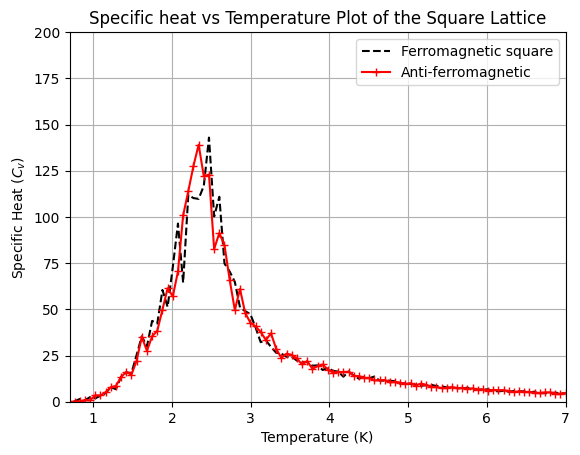

In [41]:
plt.plot(temp_range, Cv_PBC, 'k--', label='Ferromagnetic square')
plt.plot(temp_range, Cv1_PBC, 'r+-', label='Anti-ferromagnetic')
plt.xlabel("Temperature (K)")
plt.ylabel(r"Specific Heat ($C_v$)")
plt.title("Specific heat vs Temperature Plot of the Square Lattice")
plt.ylim(0,200)
plt.xlim(0.7,7)
plt.grid()
plt.legend()

In [42]:
mean_energies_PBC = mean_energy_PBC(grid_points, temp_range, nsamples=75000, mag='f')
mean_energies1_PBC = mean_energy_PBC(grid_points, temp_range, nsamples=75000, mag='af')

******************************************************
****************************************************** 



collecting energies: 100%|██████████| 100/100 [33:20<00:00, 20.01s/temperature]


******************************************************
Energy collection completed! Calculating mean energy now.
****************************************************** 



calculating mean energy: 100%|██████████| 100/100 [00:00<00:00, 523.85energy sample/s]


******************************************************
Your results are ready!
****************************************************** 

******************************************************
****************************************************** 



collecting energies: 100%|██████████| 100/100 [28:56<00:00, 17.37s/temperature]


******************************************************
Energy collection completed! Calculating mean energy now.
****************************************************** 



calculating mean energy: 100%|██████████| 100/100 [00:00<00:00, 483.42energy sample/s]

******************************************************
Your results are ready!
****************************************************** 



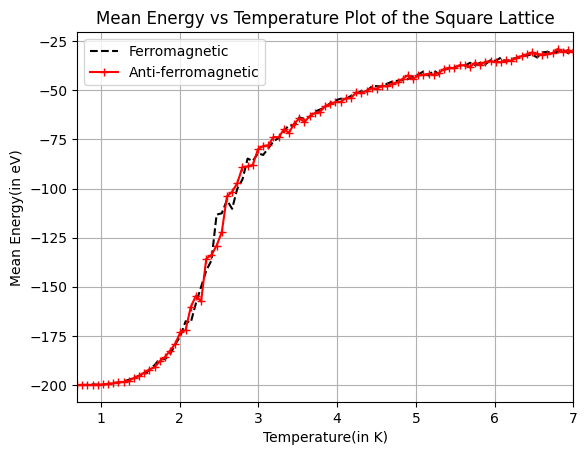

In [43]:
plt.plot(temp_range, mean_energies_PBC, 'k--', label='Ferromagnetic')
plt.plot(temp_range, mean_energies1_PBC, 'r+-', label='Anti-ferromagnetic')
plt.title(r"Mean Energy vs Temperature Plot of the Square Lattice")
plt.xlabel("Temperature(in K)")
plt.ylabel("Mean Energy(in eV)")
plt.xlim(0.7,7)
plt.legend()
plt.grid()

In [44]:
magnetization_PBC = magnetize_PBC(grid_points, temp_range, nsweep=75000, mag='f')
magnetization1_PBC = magnetize_PBC(grid_points, temp_range, nsweep=75000, mag='af')

Processing temperatures: 100%|██████████| 100/100 [29:48<00:00, 17.89s/temperature]


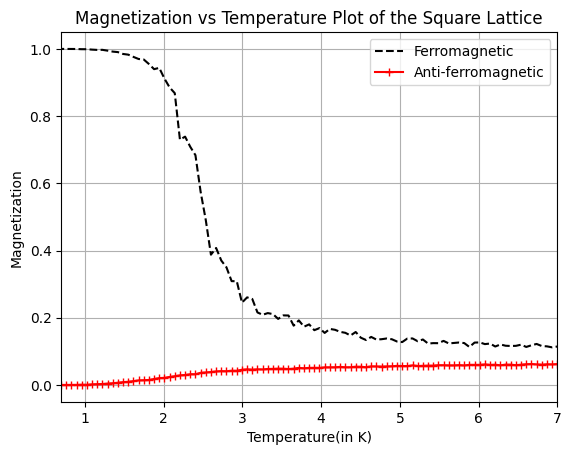

In [45]:
plt.plot(temp_range, magnetization_PBC, 'k--', label='Ferromagnetic')
plt.plot(temp_range, magnetization1_PBC, 'r+-', label='Anti-ferromagnetic')
plt.title(r"Magnetization vs Temperature Plot of the Square Lattice")
plt.xlabel("Temperature(in K)")
plt.ylabel("Magnetization")
plt.xlim(0.7,7)
plt.legend()
plt.grid()

In [46]:
X_PBC = mag_susceptibility_PBC(grid_points, temp_range, nsweep=75000, mag='f')
X1_PBC = mag_susceptibility_PBC(grid_points, temp_range, nsweep=75000, mag='af')

******************************************************
****************************************************** 



Processing temperatures: 100%|██████████| 100/100 [34:51<00:00, 20.91s/temperature]


******************************************************
Magnetic susceptibility calculation completed!
****************************************************** 

******************************************************
****************************************************** 



Processing temperatures: 100%|██████████| 100/100 [29:48<00:00, 17.89s/temperature]

******************************************************
Magnetic susceptibility calculation completed!
****************************************************** 



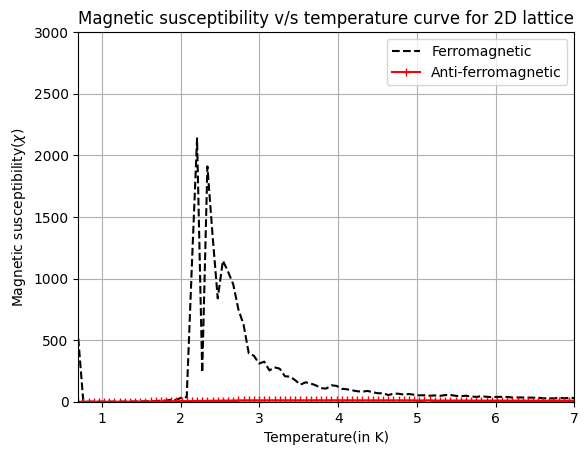

In [47]:
plt.plot(temp_range, X_PBC, 'k--', label='Ferromagnetic')
plt.plot(temp_range, X1_PBC, 'r+-', label='Anti-ferromagnetic')
plt.xlabel("Temperature(in K)")
plt.ylabel(r"Magnetic susceptibility($\chi$)")
plt.xlim(0.7,7)
plt.ylim(0,3000)
plt.title("Magnetic susceptibility v/s temperature curve for 2D lattice")
plt.grid()
plt.legend()

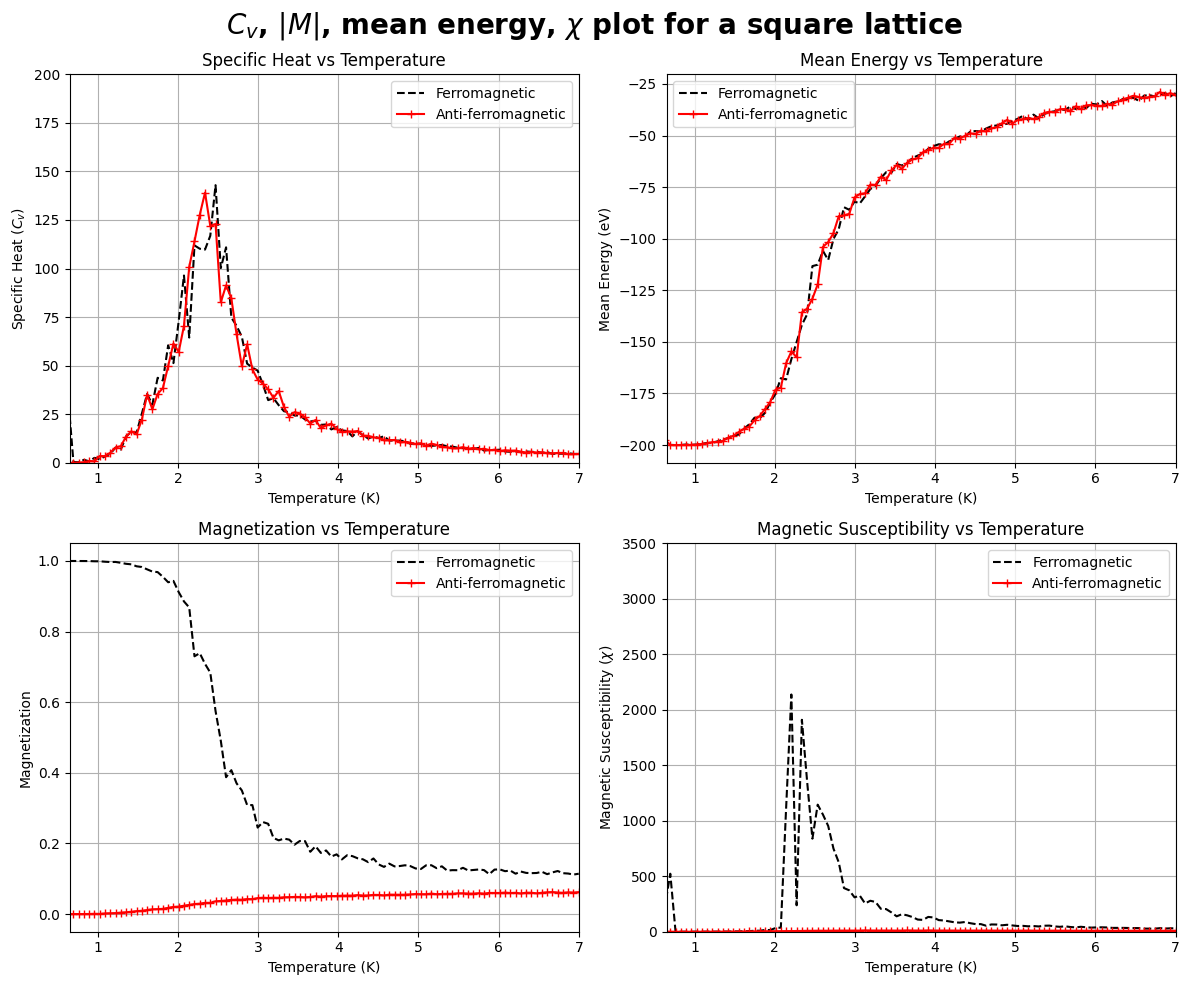

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(temp_range, Cv_PBC, 'k--', label='Ferromagnetic')
axes[0, 0].plot(temp_range, Cv1_PBC, 'r+-', label='Anti-ferromagnetic')
axes[0, 0].set_xlabel("Temperature (K)")
axes[0, 0].set_ylabel(r"Specific Heat ($C_v$)")
axes[0, 0].set_title("Specific Heat vs Temperature")
axes[0, 0].set_ylim(0, 200)
axes[0, 0].set_xlim(0.65, 7)
axes[0, 0].grid()
axes[0, 0].legend()


axes[0, 1].plot(temp_range, mean_energies_PBC, 'k--', label='Ferromagnetic')
axes[0, 1].plot(temp_range, mean_energies1_PBC, 'r+-', label='Anti-ferromagnetic')
axes[0, 1].set_xlabel("Temperature (K)")
axes[0, 1].set_ylabel("Mean Energy (eV)")
axes[0, 1].set_title("Mean Energy vs Temperature")
axes[0, 1].set_xlim(0.65, 7)
axes[0, 1].grid()
axes[0, 1].legend()


axes[1, 0].plot(temp_range, magnetization_PBC, 'k--', label='Ferromagnetic')
axes[1, 0].plot(temp_range, magnetization1_PBC, 'r+-', label='Anti-ferromagnetic')
axes[1, 0].set_xlabel("Temperature (K)")
axes[1, 0].set_ylabel("Magnetization")
axes[1, 0].set_title("Magnetization vs Temperature")
axes[1, 0].set_xlim(0.65, 7)
axes[1, 0].grid()
axes[1, 0].legend()

axes[1, 1].plot(temp_range, X_PBC, 'k--', label='Ferromagnetic')
axes[1, 1].plot(temp_range, X1_PBC, 'r+-', label='Anti-ferromagnetic')
axes[1, 1].set_xlabel("Temperature (K)")
axes[1, 1].set_ylabel(r"Magnetic Susceptibility ($\chi$)")
axes[1, 1].set_title("Magnetic Susceptibility vs Temperature")
axes[1, 1].set_xlim(0.65, 7)
axes[1, 1].set_ylim(0, 3500)
axes[1, 1].grid()
axes[1, 1].legend()
fig.suptitle(r"$C_v$, $|M|$, mean energy, $\chi$ plot for a square lattice", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


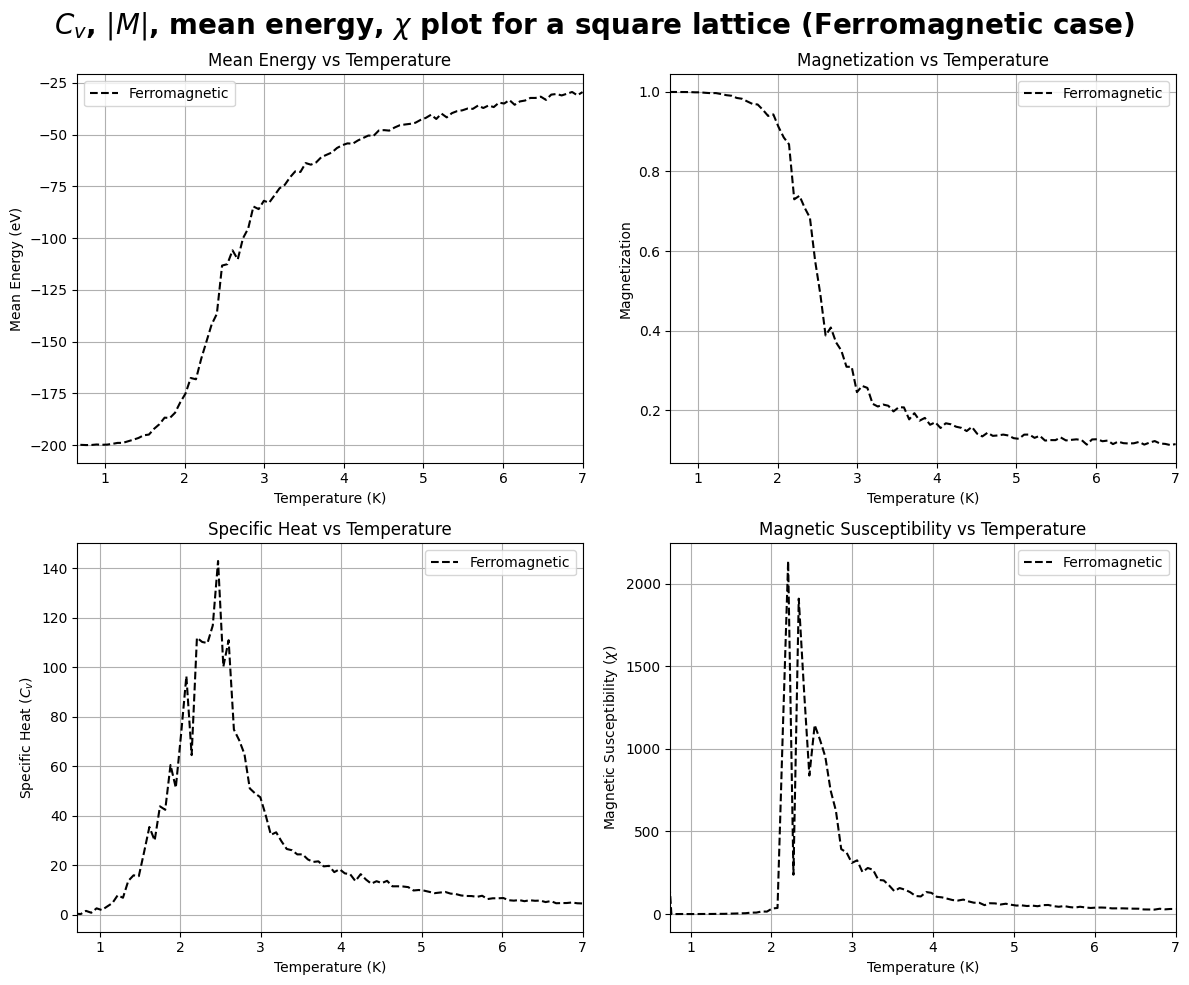

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[1, 0].plot(temp_range, Cv_PBC, 'k--', label='Ferromagnetic')
axes[1, 0].set_xlabel("Temperature (K)")
axes[1, 0].set_ylabel(r"Specific Heat ($C_v$)")
axes[1, 0].set_title("Specific Heat vs Temperature")
axes[1, 0].set_xlim(0.72, 7)
axes[1, 0].grid()
axes[1, 0].legend()


axes[0, 0].plot(temp_range, mean_energies_PBC, 'k--', label='Ferromagnetic')
axes[0, 0].set_xlabel("Temperature (K)")
axes[0, 0].set_ylabel("Mean Energy (eV)")
axes[0, 0].set_title("Mean Energy vs Temperature")
axes[0, 0].set_xlim(0.65, 7)
axes[0, 0].grid()
axes[0, 0].legend()


axes[0, 1].plot(temp_range, magnetization_PBC, 'k--', label='Ferromagnetic')
axes[0, 1].set_xlabel("Temperature (K)")
axes[0, 1].set_ylabel("Magnetization")
axes[0, 1].set_title("Magnetization vs Temperature")
axes[0, 1].set_xlim(0.65, 7)
axes[0, 1].grid()
axes[0, 1].legend()

axes[1, 1].plot(temp_range, X_PBC, 'k--', label='Ferromagnetic')
axes[1, 1].set_xlabel("Temperature (K)")
axes[1, 1].set_ylabel(r"Magnetic Susceptibility ($\chi$)")
axes[1, 1].set_title("Magnetic Susceptibility vs Temperature")
axes[1, 1].set_xlim(0.75, 7)
axes[1, 1].grid()
axes[1, 1].legend()
fig.suptitle(r"$C_v$, $|M|$, mean energy, $\chi$ plot for a square lattice (Ferromagnetic case)", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


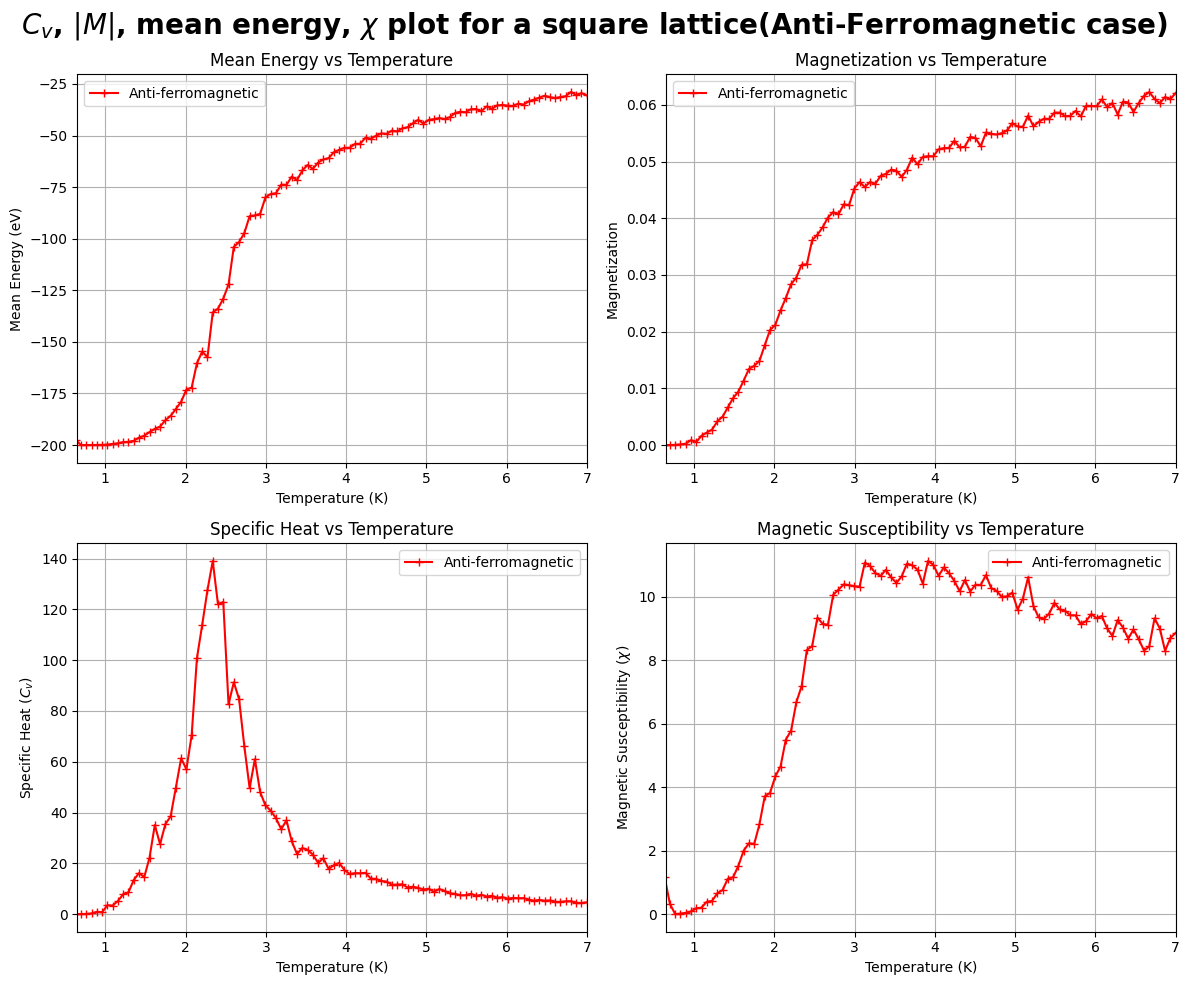

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[1, 0].plot(temp_range, Cv1_PBC, 'r+-', label='Anti-ferromagnetic')
axes[1, 0].set_xlabel("Temperature (K)")
axes[1, 0].set_ylabel(r"Specific Heat ($C_v$)")
axes[1, 0].set_title("Specific Heat vs Temperature")
axes[1, 0].set_xlim(0.65, 7)
axes[1, 0].grid()
axes[1, 0].legend()


axes[0, 0].plot(temp_range, mean_energies1_PBC, 'r+-', label='Anti-ferromagnetic')
axes[0, 0].set_xlabel("Temperature (K)")
axes[0, 0].set_ylabel("Mean Energy (eV)")
axes[0, 0].set_title("Mean Energy vs Temperature")
axes[0, 0].set_xlim(0.65, 7)
axes[0, 0].grid()
axes[0, 0].legend()

axes[0, 1].plot(temp_range, magnetization1_PBC, 'r+-', label='Anti-ferromagnetic')
axes[0, 1].set_xlabel("Temperature (K)")
axes[0, 1].set_ylabel("Magnetization")
axes[0, 1].set_title("Magnetization vs Temperature")
axes[0, 1].set_xlim(0.65, 7)
axes[0, 1].grid()
axes[0, 1].legend()

axes[1, 1].plot(temp_range, X1_PBC, 'r+-', label='Anti-ferromagnetic')
axes[1, 1].set_xlabel("Temperature (K)")
axes[1, 1].set_ylabel(r"Magnetic Susceptibility ($\chi$)")
axes[1, 1].set_title("Magnetic Susceptibility vs Temperature")
axes[1, 1].set_xlim(0.65, 7)
axes[1, 1].grid()
axes[1, 1].legend()
fig.suptitle(r"$C_v$, $|M|$, mean energy, $\chi$ plot for a square lattice(Anti-Ferromagnetic case)", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()
